In [1]:
from gibbs import *
from data_simu import *
from mcmc_plot import trace_plot, get_trace_list

## 1.Simulate Data

I simulate the data according to 

$$X= WZ + \sigma^2 I_n$$
where 

 1. $\sigma^2$ is a scalar for the noise parameter
 2. $(Z_i)_{qx1} \sim N(0, I_q)$ is the principle component vector for i-th observation
 3. $(\alpha_j)_{}$ is the precision vector parameter for $W$ matrix
 4. $(W_j)_{dx1} \sim N(0, \frac{1}{\alpha^*_j}I_d)$ is the j-th column of $W$ projection matrix

In the following simualation, I chose d = 5, q_star = 1, meaning there is only one important component driving 5 dimensional data $X$

In [2]:
# data dimension
d = 5
# true component dimension
q_star = 1
# sample size
n_sample = 1000
# true sigma2
sigma2_star = 0.8
# true component variance parameter
a_star_list = 1 / np.linspace(1,10,q_star)

In [3]:
X = generate_data(d, q_star, n_sample, sigma2_star, a_star_list)

Text(0.5, 1.0, 'Data Plot')

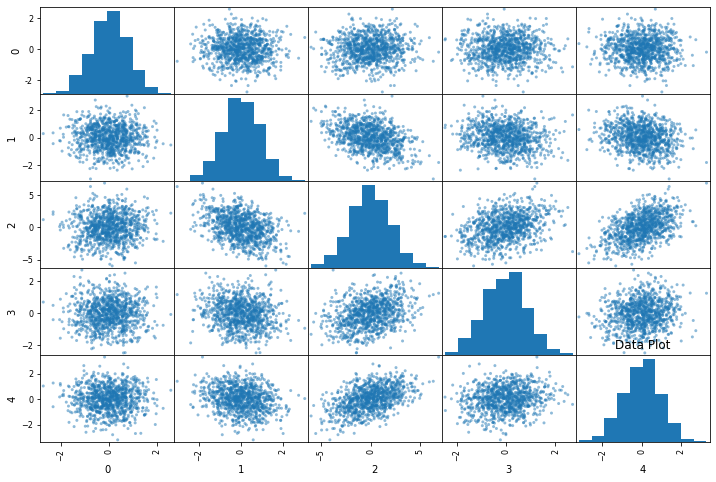

In [4]:
pd.plotting.scatter_matrix(pd.DataFrame(X).T, figsize=(12,8))
plt.title('Data Plot')

In [5]:
def component_posterior(comp_index, W_list, Z_list):
    """
        Function to plot the component residuals
        param: comp_index. list of compoents indexs used to restore the original data X
    """
    x_list=[]
    for sub_chains in range(n_chains):

        for iters in range(len(W_list[sub_chains])):
            y_hat = np.dot(W_list[sub_chains][iters][:,comp_index].reshape([d,len(comp_index)]), Z_list[sub_chains][iters][comp_index,:].reshape([len(comp_index),n_sample]))

            x_list.append(X-y_hat)
    return x_list
    

## 2. Gibbs Sampling

### 2.1 Prior Parameter Setup


In [6]:
q = d-1
prior_param = dict({'beta_sigma2':2,
      'a_sigma2':10,
      'a_aj': 1 / np.linspace(1,10,q),
      'beta_aj':1 / np.linspace(1,10,q)    
})

### 2.2 Inference Parameter Setup

In [7]:
iterations = 1000
n_chains = 3

### 2.3 Inference Sampling standard

In [8]:
mcmc_list = []
for sub_chains in range(n_chains):    
    init_dict = dict({'Z0':np.random.normal(0,1, [q, n_sample]),
            "sigma20":np.random.gamma(4,1/4),
            "w0":np.random.normal(0, 0.6, [d,q]),
            "alpha0": np.random.uniform(0,1, q)})    
                      
#    infer_dict = gibbs_scheme(X, init_dict, iterations, q, prior_param)                      
    inference = Model(X, init_dict, iterations, q, prior_param)                      
    infer_dict = inference.gibbs_result()
    mcmc_list.append(infer_dict)

In [9]:
sigma2_list = get_trace_list(mcmc_list, 'sigma2_list')
Z_list = get_trace_list(mcmc_list, 'Z_list')
W_list = get_trace_list(mcmc_list, 'W_list')
alpha_list = get_trace_list(mcmc_list, 'alpha_list')

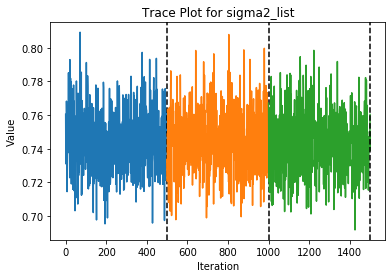

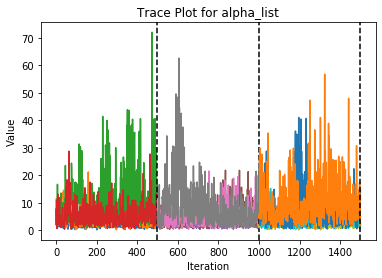

In [10]:
trace_plot(mcmc_list, var_list= ['sigma2_list', 'alpha_list'])

In [11]:
alpha_table = pd.concat([pd.DataFrame(alpha_list[i]) for i in range(n_chains)], axis=0, keys=list(range(n_chains)))

In [12]:
alpha_table

0          1          2          3
0 0    2.142087   6.662630   3.839640   7.652059
  1    3.133487   1.976692   1.911988   5.371261
  2    3.196235  11.517714   6.801606   2.952657
  3    2.376018   3.018124   6.139585  10.984585
  4    1.160444   5.364098   5.646557   4.507829
...         ...        ...        ...        ...
2 496  0.569815   4.724636   9.004219  17.489901
  497  0.675200   0.731831   3.036479   7.046844
  498  1.855628  10.914152   6.803932  11.522318
  499  3.166503   3.886399   7.119864   6.188007
  500  1.970955   4.736150  14.716218   1.672193

[1503 rows x 4 columns]

In [13]:
alpha_table.mean()

0    2.434360
1    5.008998
2    8.095447
3    8.433684
dtype: float64

In [14]:
X_hat1 = component_posterior([0,1,2],W_list,Z_list)
X_hat2 = component_posterior([0],W_list,Z_list)
X_hat3 = component_posterior([q-1],W_list,Z_list)

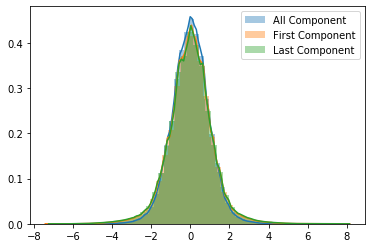

In [15]:
sns.distplot(np.array(X_hat1).ravel(),label='All Component')
sns.distplot(np.array(X_hat2).ravel(), label ='First Component')
sns.distplot(np.array(X_hat3).ravel(), label ='Last Component')
plt.legend()

### 2.4 Inference Sampling Approxmiate

In [16]:
mcmc_list = []
for sub_chains in range(n_chains):    
    init_dict = dict({'Z0':np.random.normal(0,1, [q, n_sample]),
            "sigma20":np.random.gamma(4,1/4),
            "w0":np.random.normal(0, 0.6, [d,q]),
            "alpha0": np.random.uniform(0,1, q)})    
                      
#    infer_dict = gibbs_scheme(X, init_dict, iterations, q, prior_param)                      
    inference = Model(X, init_dict, iterations, q, prior_param)                      
    infer_dict = inference.gibbs_result()

    mcmc_list.append(infer_dict)

In [17]:
sigma2_list = get_trace_list(mcmc_list, 'sigma2_list')
Z_list = get_trace_list(mcmc_list, 'Z_list')
W_list = get_trace_list(mcmc_list, 'W_list')
alpha_list = get_trace_list(mcmc_list, 'alpha_list')

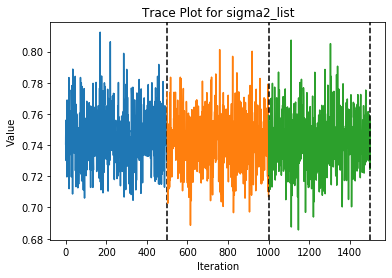

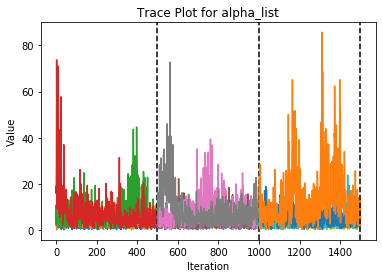

In [18]:
trace_plot(mcmc_list, var_list= ['sigma2_list', 'alpha_list'])

In [19]:
alpha_table = pd.concat([pd.DataFrame(alpha_list[i]) for i in range(n_chains)], axis=0, keys=list(range(n_chains)))

In [ ]:
alpha_table.mean()

##  3. Residual Predictive Check

In [ ]:
X_hat1 = component_posterior([0,1,2],W_list,Z_list)
X_hat2 = component_posterior([0],W_list,Z_list)
X_hat3 = component_posterior([q-1],W_list,Z_list)


In [ ]:
sns.distplot(np.array(X_hat1).ravel(),label='All Component')
sns.distplot(np.array(X_hat2).ravel(), label ='First Component')
sns.distplot(np.array(X_hat3).ravel(), label ='Last Component')
plt.legend()

In [ ]:
alpha_table[alpha_table.index.get_level_values(0)==0].mean()

In [ ]:
alpha_table[alpha_table.index.get_level_values(0)==1].mean()

In [ ]:
alpha_table[alpha_table.index.get_level_values(0)==2].mean()